In [1]:
import sys
sys.path.append('../')

In [2]:
import os
import json
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers, callbacks, regularizers, models
from keras.models import load_model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from util import save_history, save_model, plot_metrics, plot_visualizations

In [3]:
model_version = "v10.0"
base_model_version = 'v10.0'

In [4]:
seed_value = 42

os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [5]:
with open('../data_schema.json', 'r') as f:
    config = json.load(f)
    
spectro_cols = config['spectro_cols']
photo_cols = config['photometry_cols']
generic_cols = config['generic_cols']
target_col = config['target_col']

In [6]:
df = pd.read_csv(f"../data/processed/photometry_only.csv")

X = df[photo_cols + generic_cols]
y = df[target_col]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed_value)

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
# === Step 1: Build Base Model (originally trained on 58 features) ===
def build_base_model(input_dim):
    base_inputs = keras.Input(shape=(input_dim,), name='Input')

    x = layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), name='Dense_64')(base_inputs)
    x = layers.BatchNormalization(name='BN_64')(x)
    x = layers.Activation('relu', name='Act_64')(x)
    x = layers.Dropout(0.2, name='Dropout_64')(x)

    x = layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), name='Dense_128')(x)
    x = layers.BatchNormalization(name='BN_128')(x)
    x = layers.Activation('relu', name='Act_128')(x)
    x = layers.Dropout(0.2, name='Dropout_128')(x)

    x = layers.Dense(256, kernel_regularizer=regularizers.l2(0.001), name='Dense_256')(x)
    x = layers.BatchNormalization(name='BN_256')(x)
    x = layers.Activation('relu', name='Act_256')(x)
    x = layers.Dropout(0.2, name='Dropout_256')(x)

    x = layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), name='Dense_128_2')(x)
    x = layers.BatchNormalization(name='BN_128_2')(x)
    x = layers.Activation('relu', name='Act_128_2')(x)
    x = layers.Dropout(0.2, name='Dropout_128_2')(x)

    base_outputs = layers.Dense(1, name='Output')(x)

    model = keras.Model(inputs=base_inputs, outputs=base_outputs, name='Base_Model')
    return model

# === Step 2: Initialize and Load Weights ===
base_model = build_base_model(input_dim=len([spectro_cols + photo_cols + generic_cols][0]))  # Declare dimension explicitly here for compatibility
base_model.load_weights(f"../models/{base_model_version}/spec_photo_model.h5", 
                        by_name=True, 
                        skip_mismatch=True)

# === Step 3: Freeze Base Layers ===
for layer in base_model.layers:
    layer.trainable = False

# === Step 4: Build Transfer Model ===
transfer_input_dim = X_train_scaled.shape[1]  # Automatically adapts to new data
transfer_inputs = keras.Input(shape=(transfer_input_dim,), name='Transfer_Input')

# Project 39 features → base model input size
projection_dim = base_model.input_shape[1]  # Fetches '58' dynamically
x = layers.Dense(projection_dim, activation='relu', name='Input_Projection')(transfer_inputs)

# Connect to base model
x = base_model(x)

# Add task-specific head
x = layers.Dense(64, activation='relu', name='Transfer_Head_64')(x)
x = layers.Dropout(0.3, name='Transfer_Dropout')(x)

# Final output layer
transfer_outputs = layers.Dense(1, name='Transfer_Output')(x)

# Construct the full transfer model
transfer_model = keras.Model(inputs=transfer_inputs, outputs=transfer_outputs, name='Transfer_Model')

# === Step 5: Compile and Summarize ===
transfer_model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss=tf.keras.losses.Huber(),
    metrics=['mae', 'mse']
)

transfer_model.summary()

# Optional callback
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

Model: "Transfer_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Transfer_Input (InputLayer)  [(None, 39)]             0         
                                                                 
 Input_Projection (Dense)    (None, 58)                2320      
                                                                 
 Base_Model (Functional)     (None, 1)                 80449     
                                                                 
 Transfer_Head_64 (Dense)    (None, 64)                128       
                                                                 
 Transfer_Dropout (Dropout)  (None, 64)                0         
                                                                 
 Transfer_Output (Dense)     (None, 1)                 65        
                                                                 
Total params: 82,962
Trainable params: 2,513
Non-tra

In [13]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)
history = transfer_model.fit(X_train_scaled, y_train, epochs=200, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping])

Epoch 1/200
4467/4467 [==============================] - 28s 6ms/step - loss: 0.7358 - mae: 1.1338 - mse: 2.2273 - val_loss: 0.0387 - val_mae: 0.2135 - val_mse: 0.0680
Epoch 2/200
4467/4467 [==============================] - 28s 6ms/step - loss: 0.5082 - mae: 0.8862 - mse: 1.2438 - val_loss: 0.0371 - val_mae: 0.2017 - val_mse: 0.0654
Epoch 3/200
4467/4467 [==============================] - 29s 6ms/step - loss: 0.4200 - mae: 0.7842 - mse: 0.9767 - val_loss: 0.0432 - val_mae: 0.2338 - val_mse: 0.0780
Epoch 4/200
4467/4467 [==============================] - 28s 6ms/step - loss: 0.3369 - mae: 0.6842 - mse: 0.7454 - val_loss: 0.0320 - val_mae: 0.1712 - val_mse: 0.0568
Epoch 5/200
4467/4467 [==============================] - 29s 7ms/step - loss: 0.2600 - mae: 0.5857 - mse: 0.5516 - val_loss: 0.0362 - val_mae: 0.1896 - val_mse: 0.0660
Epoch 6/200
4467/4467 [==============================] - 29s 6ms/step - loss: 0.1952 - mae: 0.4951 - mse: 0.4010 - val_loss: 0.0305 - val_mae: 0.1368 - val_mse:

In [14]:
y_pred = transfer_model.predict(X_test_scaled)

1396/1396 [==============================] - 3s 2ms/step


In [15]:
plot_metrics(y_test, y_pred)

Evaluation Metrics:
Mean Absolute Error (MAE): 0.1056
Root Mean Squared Error (RMSE): 0.1994
R² Score: 0.9087


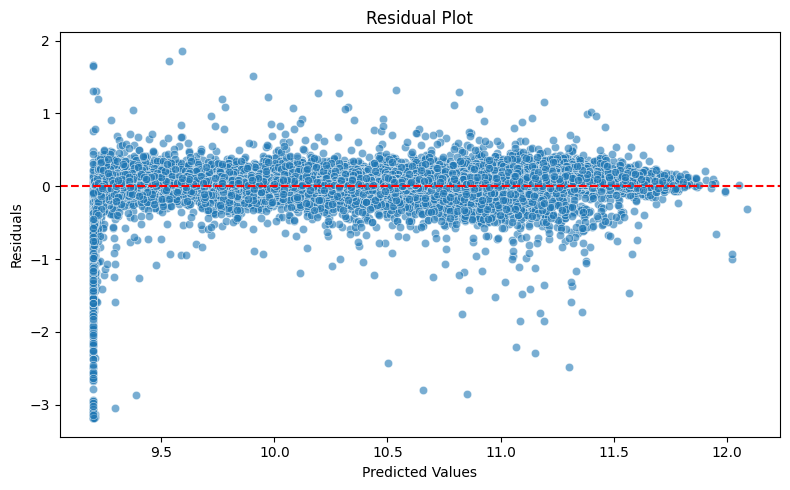

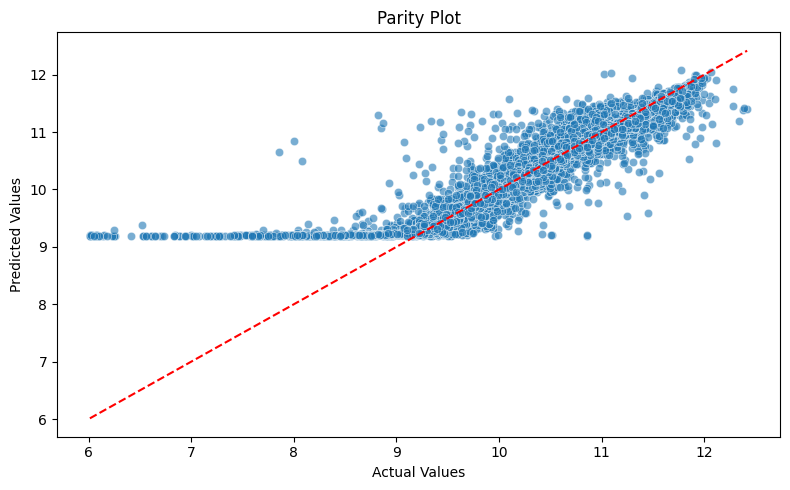

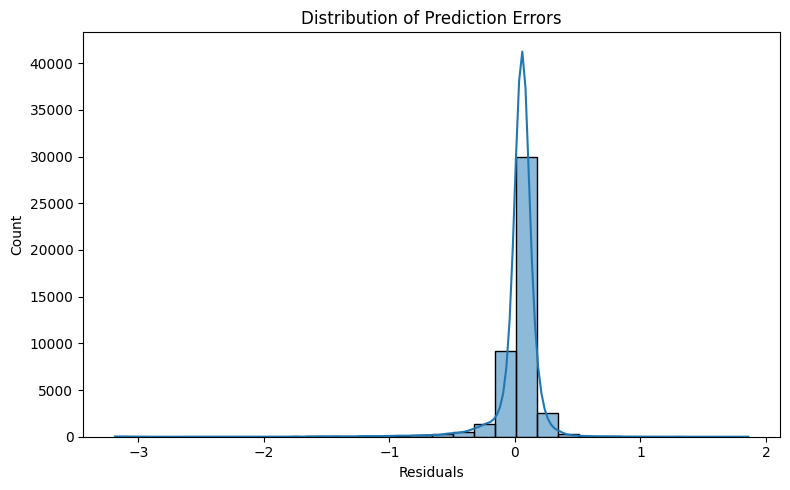

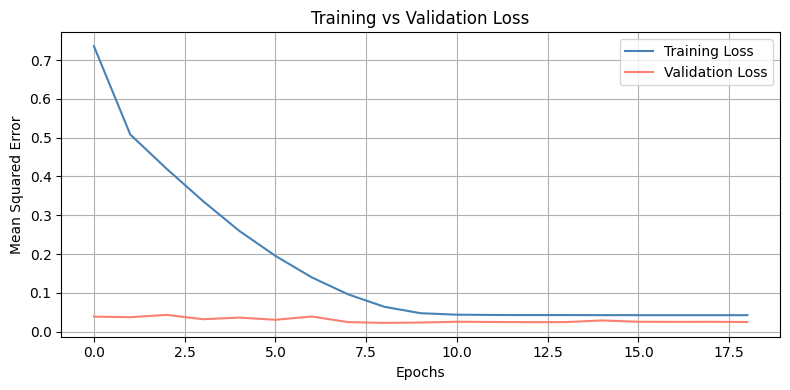

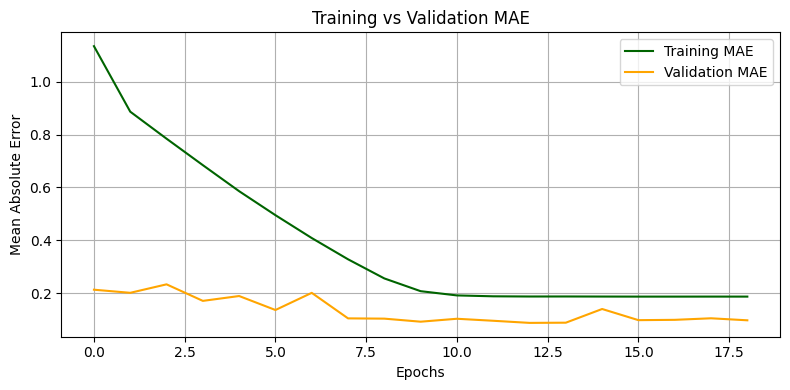

In [16]:
plot_visualizations(history, y_test, y_pred)

In [17]:
save_history(history, model_version, 'history_photo_only')

In [18]:
save_model(transfer_model, model_version, 'photo_only_model.h5')

In [19]:
df_unseen = pd.read_csv(f"../data/processed/unseen_data.csv")

X_unseen = df_unseen[photo_cols + generic_cols]
y_unseen = df_unseen[target_col]

In [20]:
X_unseen_scaled = scaler.transform(X_unseen)

In [21]:
y_pred_unseen = transfer_model.predict(X_unseen_scaled)

6980/6980 [==============================] - 15s 2ms/step


In [22]:
plot_metrics(y_unseen, y_pred_unseen)

Evaluation Metrics:
Mean Absolute Error (MAE): 0.1043
Root Mean Squared Error (RMSE): 0.1957
R² Score: 0.9105


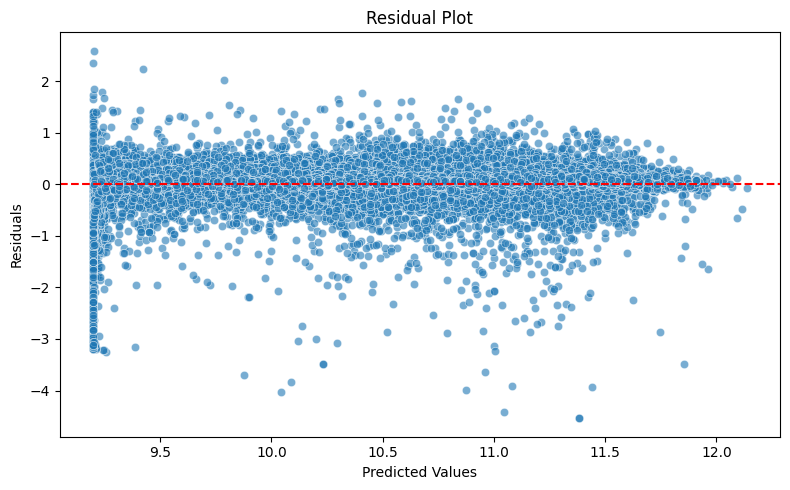

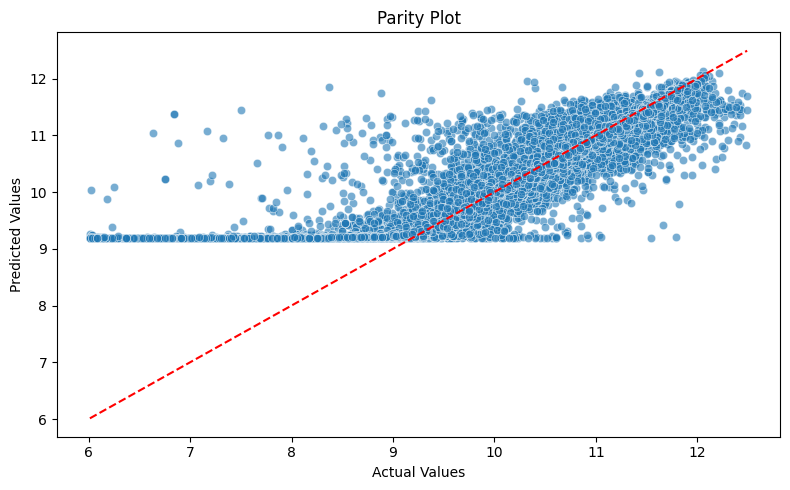

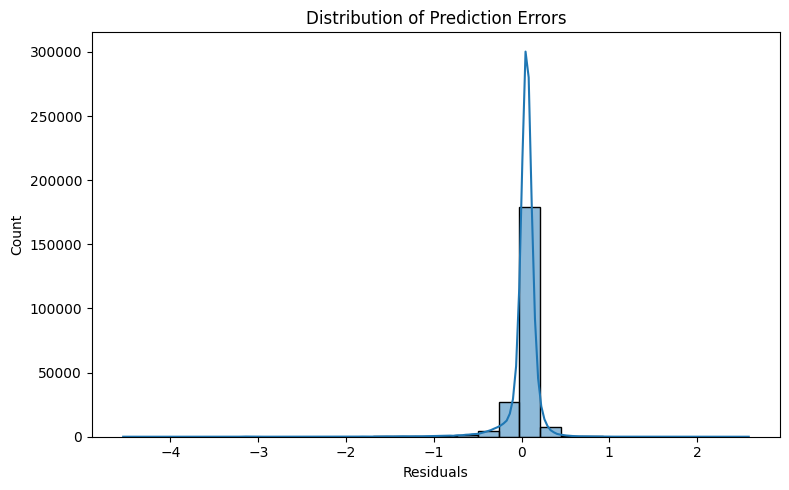

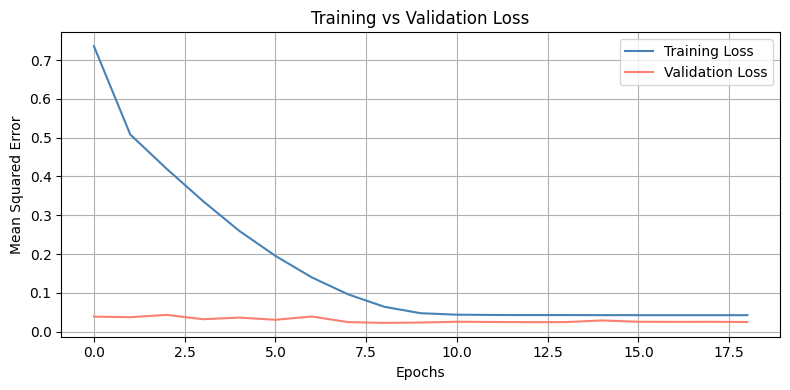

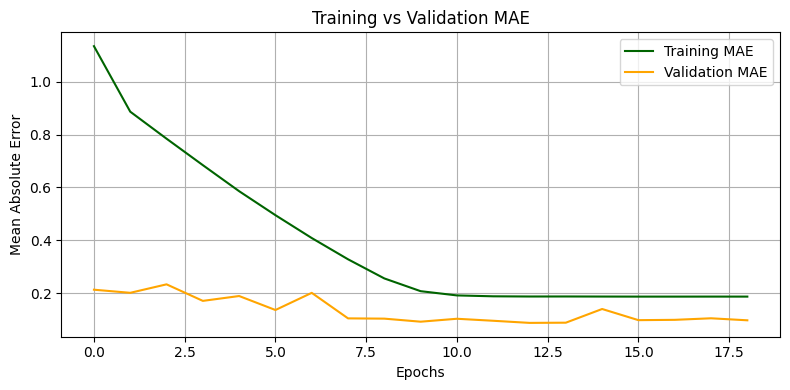

In [26]:
plot_visualizations(history, y_unseen, y_pred_unseen)